In [1]:
import torchvision
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.hub
import traceback
import crypten
from PIL import Image
from torchvision.io import read_image
from torchvision.models import ConvNeXt_Tiny_Weights
from pathlib import Path
import numpy as np
from torch import tensor
import re
import inspect
import os
import urllib.request
import json

# Data

In [2]:

def load_image(path, show=False):
    img = read_image(path)
#     with open(path, "rb") as fp:
#         img = Image.open(fp)
#         return img
    if img is None:
        return None
    if show:
        plt.imshow(transforms.ToPILImage()(img))
        plt.axis('off')
    return img

tensor([[[ 73,  59,  64,  ...,  86,  83,  79],
         [ 74,  71,  71,  ...,  83,  89,  92],
         [ 75,  61,  57,  ...,  81,  88,  92],
         ...,
         [ 51,  49,  58,  ..., 217, 218, 211],
         [ 48,  54,  63,  ..., 221, 211, 191],
         [ 45,  55,  58,  ..., 160, 163, 179]],

        [[ 92,  94,  92,  ..., 108, 110, 113],
         [ 94,  98,  98,  ..., 111, 108, 107],
         [ 97,  94,  98,  ..., 112, 108, 105],
         ...,
         [ 82,  77,  75,  ..., 191, 219, 205],
         [ 79,  76,  79,  ..., 226, 219, 214],
         [ 74,  72,  72,  ..., 180, 180, 184]],

        [[125, 136, 139,  ..., 157, 153, 151],
         [131, 128, 127,  ..., 150, 150, 148],
         [121, 129, 128,  ..., 158, 158, 157],
         ...,
         [ 87,  78,  82,  ..., 200, 214, 205],
         [ 64,  63,  66,  ..., 229, 222, 204],
         [ 54,  53,  55,  ..., 189, 196, 190]]], dtype=torch.uint8)

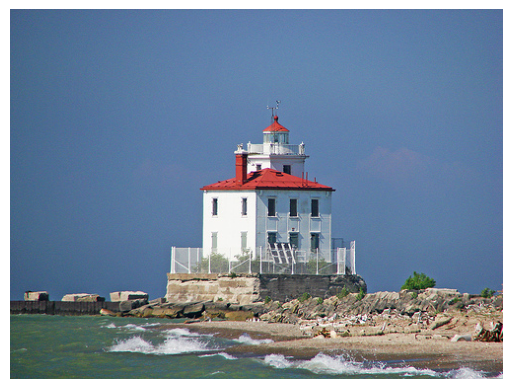

In [3]:
img_path = "/home/amin/repos/ma-praxis-related/imagenet-sample-images/n02894605_breakwater.JPEG"
load_image(img_path, show=True)

In [4]:
def ToRGB(x):
    if x.shape[0]==1:
        return  x.repeat(3, 1, 1)
    return x

In [5]:
t = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ToRGB
    ])

In [6]:

t = transforms.Compose([
    ToRGB,
    transforms.ToPILImage(),
    ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms()
])

In [7]:

img_dataset = "/home/amin/repos/ma-praxis-related/imagenet-sample-images/"
pathlist = list(Path(img_dataset).glob('*.JPEG'))
pathlist = pathlist[125:126]
images_src = []
images = []
labels = []

def process_img(img):
    img = t(img)
    img = img.unsqueeze(0)
    return img

for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    img = load_image(path_in_str)
    images_src.append(transforms.ToPILImage()(img))
    img = process_img(img)
    images.append(img)
    labels.append(path.stem)
images_t = torch.cat(images)

In [8]:

np.save("../datasets/image_cls/test.npy", images_t.numpy())

In [9]:
images_np = np.load("images.npy")


In [10]:

images_t_1 = tensor(images_np)

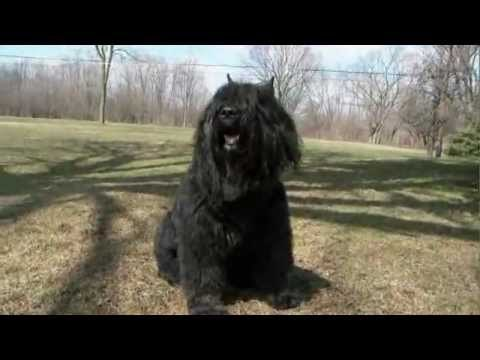

In [11]:
images_src[0]

In [12]:
labels_mapping = []
with open("ImageNetMapping.txt", "r") as fp:
    labels_mapping = fp.readlines()
labels_mapping


['n01440764 tench, Tinca tinca\n',
 'n01443537 goldfish, Carassius auratus\n',
 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\n',
 'n01491361 tiger shark, Galeocerdo cuvieri\n',
 'n01494475 hammerhead, hammerhead shark\n',
 'n01496331 electric ray, crampfish, numbfish, torpedo\n',
 'n01498041 stingray\n',
 'n01514668 cock\n',
 'n01514859 hen\n',
 'n01518878 ostrich, Struthio camelus\n',
 'n01530575 brambling, Fringilla montifringilla\n',
 'n01531178 goldfinch, Carduelis carduelis\n',
 'n01532829 house finch, linnet, Carpodacus mexicanus\n',
 'n01534433 junco, snowbird\n',
 'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea\n',
 'n01558993 robin, American robin, Turdus migratorius\n',
 'n01560419 bulbul\n',
 'n01580077 jay\n',
 'n01582220 magpie\n',
 'n01592084 chickadee\n',
 'n01601694 water ouzel, dipper\n',
 'n01608432 kite\n',
 'n01614925 bald eagle, American eagle, Haliaeetus leucocephalus\n',
 'n01616318 vulture\

In [13]:
num_size = len("n01440764")

labels_mapping = [l[:num_size] for l in labels_mapping]
del num_size

labels_mapping[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [14]:
labels_index_mapping = dict()
for index, label in enumerate(labels_mapping):
    labels_index_mapping[label] = index


In [15]:
num_size = len("n01440764")
labels = [labels_index_mapping[l[:num_size]] for l in labels]
labels[:10]

[233]

In [16]:
labels_np = torch.tensor(labels).numpy()
np.save("../datasets/image_cls/test_labels.npy", labels_np)

In [17]:
os.path.join("../datasets/image_cls/", "test_labels.npy")

'../datasets/image_cls/test_labels.npy'

# Models

In [6]:


pattern = re.compile(r"autoclass:: ([\w\.]+)\n")

def get_weights_class_name(model_name="alexnet"):
    try:
        f = getattr(torchvision.models, model_name)
    except AttributeError:
        return None
    d = f.__doc__
    match = pattern.search(d)
    if match is not None:
        return eval(match.group(1) + ".DEFAULT")
    return None

In [17]:
m_weight_mapping = None

def get_weights_class_name(model_name="alexnet"):
    if model_name not in m_weight_mapping or m_weight_mapping[model_name] is None:
        return None
    weight_cl_path = m_weight_mapping[model_name]
    try:
        return eval(weight_cl_path + ".DEFAULT")
    except AttributeError:
        return None

In [25]:

img_dataset = "/home/amin/repos/ma-praxis-related/imagenet-sample-images/"



def load_dataset(transform):
    pathlist = Path(img_dataset).glob('*.JPEG')
    images = []
    labels = []
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        img = load_image(path_in_str)
        img = ToRGB(img)
        img = transform(img)
        img = img.unsqueeze(0)
        images.append(img)
        labels.append(path.stem)
    return torch.cat(images), labels

In [53]:

def store_vision_model(model_name, file_name):
    dummy_input = torch.randn(1, 3, 224, 224)
    m = getattr(torchvision.models.quantization, model_name)(pretrained=True)
    torch.onnx.export(m, dummy_input, file_name)
    return m

def store_vision_model_2(model_name, file_name):
    dummy_input = torch.randn(1, 3, 224, 224)
    weights = get_weights_class_name(model_name)
    if weights is None:
        raise Exception("No weights found: " + model_name)
    model = torch.hub.load(repo_, model_name, weights=weights)
#     m = torch.hub.load(repo_, "resnet50", weights="IMAGENET1K_V2")
    m = getattr(torchvision.models, model_name)(weights=weights)
    torch.onnx.export(m, dummy_input, file_name)
    return m, weights

def vision_model_file_name(model_name):
    file_name = "../pre_trained_models/vision5/{}.onnx".format(model_name)
    return file_name
os.mkdir("../pre_trained_models/vision5/")

In [55]:
crypten.init()
repo_ = "pytorch/vision:v0.13.0"
m_list = torch.hub.list(repo_)
success_list = set()
model_data = dict()

/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)
Using cache found in /home/amin/.cache/torch/hub/pytorch_vision_v0.13.0


In [56]:
quantized_m_list = ["googlenet", "inception_v3", "mobilenet_v2", 
          "mobilenet_v3_large", "resnet18", "resnet50", "resnext101_32x8d", "resnext101_64x4d",
         "shufflenet_v2_x0_5", "shufflenet_v2_x1_0", "shufflenet_v2_x1_5", "shufflenet_v2_x2_0"]
m_list = quantized_m_list
# success_list = set()


In [57]:
for m_name in m_list:
    if m_name in success_list:
        print(f"Skipping, already succeeded: {m_name}")
        continue
    file_name = vision_model_file_name(m_name)
    try:
        print(f"Downloading {m_name}")
        model = store_vision_model(m_name, file_name)
#         images_t, labels = load_dataset(weights.transforms())
#         with open(file_name, "rb") as fp:
#             model_crypten = crypten.nn.from_onnx(fp)
#         model(images_t[0].unsqueeze(0))
#         enc_model = model_crypten.encrypt()
#         x = crypten.cryptensor(images_t[0].unsqueeze(0))
#         enc_model(x)
#         model_data[m_name] = {
#             "images": images_t,
#             "labels": labels,
#             "model": model,
#             "weights": weights
#         }
        success_list.add(m_name)
    except Exception:
        print("Couldn't prep: " + m_name)
        traceback.print_exc()
        if file_name is not None and os.path.isfile(file_name):
            os.remove(file_name)
            

/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Couldn't prep: resnext101_64x4d


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/3194211907.py", line 8, in <cell line: 1>
    model = store_vision_model(m_name, file_name)
  File "/tmp/ipykernel_325661/1009132274.py", line 3, in store_vision_model
    m = getattr(torchvision.models.quantization, model_name)(pretrained=True)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/resnet.py", line 460, in resnext101_64x4d
    return _resnet(QuantizableBottleneck, [3, 4, 23, 3], weights, progress, quantize, **kwargs)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/resnet.py", line 141, in _resnet
    model = QuantizableResNet(block, layers, **kwargs)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/resnet.py", line 100, in __init__
    super().__init__(*args, **kwargs)
TypeError: __init__() got an unexpected keyword argument 'pretrained'
/home/amin/miniconda3/en

/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Couldn't prep: shufflenet_v2_x1_5
Couldn't prep: shufflenet_v2_x2_0


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/3194211907.py", line 8, in <cell line: 1>
    model = store_vision_model(m_name, file_name)
  File "/tmp/ipykernel_325661/1009132274.py", line 3, in store_vision_model
    m = getattr(torchvision.models.quantization, model_name)(pretrained=True)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/shufflenetv2.py", line 352, in shufflenet_v2_x1_5
    return _shufflenetv2(
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/shufflenetv2.py", line 105, in _shufflenetv2
    model = QuantizableShuffleNetV2(stages_repeats, stages_out_channels, **kwargs)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torchvision/models/quantization/shufflenetv2.py", line 55, in __init__
    super().__init__(*args, inverted_residual=QuantizableInvertedResidual, **kwargs)  # type: ignore[misc]
TypeError: __init__() got an unexpected ke

In [26]:
success_list

{'googlenet',
 'inception_v3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'resnet18',
 'resnet50',
 'resnext101_32x8d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0'}

In [28]:
try:
    if success_load is None:
        success_load = dict()
except:
    success_load = dict()
try:
    if success_load_crypten is None:
        success_load_crypten = dict()
except:
    success_load_crypten = dict()

In [33]:
stored_models = Path("../pre_trained_models/vision5/").glob('*.onnx')

for stored_m in stored_models:
    try:
        m = load_nn(stored_m)
        m(images_t[0].unsqueeze(0))
        success_load.add(stored_m)
    except KeyboardInterrupt:
        raise
    except:
        print("Couldn't load " + str(stored_m))
        traceback.print_exc()
success_load

Loaded from ../pre_trained_models/vision5/mobilenet_v2.onnx
Loaded from ../pre_trained_models/vision5/googlenet.onnx
Loaded from ../pre_trained_models/vision5/resnet50.onnx
Couldn't load ../pre_trained_models/vision5/mobilenet_v3_large.onnx


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2737419590.py", line 5, in <cell line: 3>
    m = load_nn(stored_m)
  File "/tmp/ipykernel_325661/1972650342.py", line 6, in load_nn
    pytorch_model = ConvertModel(onnx_model, experimental=True)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/onnx2pytorch/convert/model.py", line 122, in __init__
    for op_id, op_name, op in convert_operations(
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/onnx2pytorch/convert/operations.py", line 279, in convert_operations
    raise NotImplementedError(
NotImplementedError: Conversion not implemented for op_type=HardSigmoid.


Loaded from ../pre_trained_models/vision5/resnext101_32x8d.onnx
Loaded from ../pre_trained_models/vision5/shufflenet_v2_x0_5.onnx
Loaded from ../pre_trained_models/vision5/inception_v3.onnx
Couldn't load ../pre_trained_models/vision5/inception_v3.onnx
Loaded from ../pre_trained_models/vision5/shufflenet_v2_x1_0.onnx
Loaded from ../pre_trained_models/vision5/resnet18.onnx


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2737419590.py", line 6, in <cell line: 3>
    m(images_t[0].unsqueeze(0))
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/onnx2pytorch/convert/model.py", line 212, in forward
    activations[out_op_id] = op(in_activations)
RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 3 for tensor number 3 in the list.


{PosixPath('../pre_trained_models/vision5/googlenet.onnx'),
 PosixPath('../pre_trained_models/vision5/mobilenet_v2.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet18.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet50.onnx'),
 PosixPath('../pre_trained_models/vision5/resnext101_32x8d.onnx'),
 PosixPath('../pre_trained_models/vision5/shufflenet_v2_x0_5.onnx'),
 PosixPath('../pre_trained_models/vision5/shufflenet_v2_x1_0.onnx')}

In [35]:
stored_models = list(Path("../pre_trained_models/vision5/").glob('*.onnx'))

for index, stored_m in enumerate(stored_models):
    print(f"Trying crypten load and inference: {stored_m}. It is {index}/{len(stored_models)}")
    try:
        with open(stored_m, "rb") as fp:
            model_crypten = crypten.nn.from_onnx(fp)
        enc_model = model_crypten.encrypt()
        x = crypten.cryptensor(images_t[0].unsqueeze(0))
        enc_model(x)
        success_load_crypten.add(stored_m)
    except KeyboardInterrupt:
        raise
    except:
        print("Couldn't crypten load " + str(stored_m))
        traceback.print_exc()
success_load_crypten

Trying crypten load and inference: ../pre_trained_models/vision5/mobilenet_v2.onnx. It is 0/9
Trying crypten load and inference: ../pre_trained_models/vision5/googlenet.onnx. It is 1/9
Couldn't crypten load ../pre_trained_models/vision5/googlenet.onnx
Trying crypten load and inference: ../pre_trained_models/vision5/resnet50.onnx. It is 2/9


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2617540511.py", line 7, in <cell line: 3>
    model_crypten = crypten.nn.from_onnx(fp)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 36, in from_onnx
    return _to_crypten(onnx_model)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 175, in _to_crypten
    crypten_module = crypten_class.from_onnx(attributes=attributes)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/module.py", line 1312, in from_onnx
    dimension = attributes["axes"]
KeyError: 'axes'


Trying crypten load and inference: ../pre_trained_models/vision5/mobilenet_v3_large.onnx. It is 3/9
Couldn't crypten load ../pre_trained_models/vision5/mobilenet_v3_large.onnx
Trying crypten load and inference: ../pre_trained_models/vision5/resnext101_32x8d.onnx. It is 4/9


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2617540511.py", line 7, in <cell line: 3>
    model_crypten = crypten.nn.from_onnx(fp)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 36, in from_onnx
    return _to_crypten(onnx_model)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 172, in _to_crypten
    crypten_class = _get_operator_class(node.op_type, attributes)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 248, in _get_operator_class
    raise ValueError(f"CrypTen does not support ONNX op {node_op_type}.")
ValueError: CrypTen does not support ONNX op HardSigmoid.


Trying crypten load and inference: ../pre_trained_models/vision5/shufflenet_v2_x0_5.onnx. It is 5/9
Couldn't crypten load ../pre_trained_models/vision5/shufflenet_v2_x0_5.onnx
Trying crypten load and inference: ../pre_trained_models/vision5/inception_v3.onnx. It is 6/9
Couldn't crypten load ../pre_trained_models/vision5/inception_v3.onnx
Trying crypten load and inference: ../pre_trained_models/vision5/shufflenet_v2_x1_0.onnx. It is 7/9
Couldn't crypten load ../pre_trained_models/vision5/shufflenet_v2_x1_0.onnx
Trying crypten load and inference: ../pre_trained_models/vision5/resnet18.onnx. It is 8/9


Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2617540511.py", line 7, in <cell line: 3>
    model_crypten = crypten.nn.from_onnx(fp)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 36, in from_onnx
    return _to_crypten(onnx_model)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 165, in _to_crypten
    crypten_model.add_module(node.name, module.Parameter(param), [])
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/module.py", line 948, in __init__
    self.register_parameter("data", param)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/module.py", line 126, in register_parameter
    param.requires_grad = requires_grad
RuntimeError: only Tensors of floating point and complex dtype can require gradients
Traceback (most recent call last):
  File "/tmp/ipykernel_325661/2617540511.py", line 7, in <cell l

{PosixPath('../pre_trained_models/vision5/mobilenet_v2.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet18.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet50.onnx'),
 PosixPath('../pre_trained_models/vision5/resnext101_32x8d.onnx')}

In [21]:

crypten.init()

stored_models = Path("../pre_trained_models/vision5/").glob('*.onnx')
for stored_m in stored_models:
    try:
        m = load_nn(stored_m)
        m(images_t[0].unsqueeze(0))
        success_load.add(stored_m)
    except:
        print("Couldn't load " + str(stored_m))
        traceback.print_exc()
    
    try:
        with open(stored_m, "rb") as fp:
            model_crypten = crypten.nn.from_onnx(fp)
        enc_model = model_crypten.encrypt()
        x = crypten.cryptensor(images_t[0].unsqueeze(0))
        enc_model(x)
        success_load_crypten.add(stored_m)
    except:
        print("Couldn't crypten load " + str(stored_m))
        traceback.print_exc()
    

Loaded from ../pre_trained_models/vision5/googlenet.onnx
Couldn't crypten load ../pre_trained_models/vision5/googlenet.onnx


Traceback (most recent call last):
  File "/tmp/ipykernel_288796/1465898369.py", line 17, in <cell line: 6>
    model_crypten = crypten.nn.from_onnx(fp)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 36, in from_onnx
    return _to_crypten(onnx_model)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/onnx_converter.py", line 175, in _to_crypten
    crypten_module = crypten_class.from_onnx(attributes=attributes)
  File "/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/crypten/nn/module.py", line 1312, in from_onnx
    dimension = attributes["axes"]
KeyError: 'axes'


In [49]:
success_list

{'googlenet',
 'inception_v3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'resnet18',
 'resnet50',
 'resnext101_32x8d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0'}

In [52]:
success_load_crypten

{PosixPath('../pre_trained_models/vision5/mobilenet_v2.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet18.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet50.onnx'),
 PosixPath('../pre_trained_models/vision5/resnext101_32x8d.onnx')}

In [51]:
success_load_crypten.difference(success_list)

{PosixPath('../pre_trained_models/vision5/mobilenet_v2.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet18.onnx'),
 PosixPath('../pre_trained_models/vision5/resnet50.onnx'),
 PosixPath('../pre_trained_models/vision5/resnext101_32x8d.onnx')}

In [118]:
enc_model = model_crypten.encrypt()
x = crypten.cryptensor(images_t[0].unsqueeze(0))
enc_model(x)

MPCTensor(
	_tensor=tensor([[  63761654543681,   32091942792063,   15068668209741,   17013118313414,
         -136993926262839,   33027115900332,    6852135303925,  -29388839068906,
           32811290796678,   67055838367776, -129577839948070,  -82407195950444,
          -33663107769052,  -30062082806294,  -32165526506307,   -3339993542550,
          -83438400399641,  -84901933801312,  -55420667723370,  -78004893077098,
         -110502313063426, -115746755733859,   34430410849539,    4295955824692,
          -87389160217983, -103277854985654,  -58106986337460,   23896891313300,
          136011402441417,   -2922366749628,  -42132399275883,  -28384145860704,
         -122175840686362, -108615024819878,  115245115413726,   36677781448467,
          -48557204279429,    8516281822565,  135875926829566,  -73139846233720,
          129531929069153, -103932621824759,  -62496538696948,   88774509013152,
          -43667484210956,    5194443148898,  -14290017332453, -113215659397852,
        

In [36]:
torch_working_models = []
for m in success_load:
    torch_working_models.append(m.name)
import json
with open("./torch_working_models_quant.json", "w") as fp:
    json.dump(torch_working_models, fp)
crypt_working_models = []
for m in success_load_crypten:
    crypt_working_models.append(m.name)
import json
with open("./crypt_working_models_quant.json", "w") as fp:
    json.dump(crypt_working_models, fp)

In [94]:
with open("../pre_trained_models/vision/alexnet.onnx", "rb") as fp:
    model_crypten = crypten.nn.from_onnx(fp)

In [13]:
crypten.init()
model_crypten.encrypt()

NameError: name 'model_crypten' is not defined

In [31]:
def load_nn(file_name):
    import onnx
    from onnx2pytorch import ConvertModel

    onnx_model = onnx.load(file_name)
    pytorch_model = ConvertModel(onnx_model, experimental=True)
    print(f'Loaded from {file_name}')
    return pytorch_model


In [70]:
# m = load_nn("../pre_trained_models/vision/alexnet.onnx")
m = load_nn("../pre_trained_models/image_cls/convnext_small.onnx")

Loaded from ../pre_trained_models/image_cls/convnext_small.onnx


/home/amin/miniconda3/envs/ma3/lib/python3.9/site-packages/onnx2pytorch/convert/model.py:147: UserWarning: Using experimental implementation that allows 'batch_size > 1'.Batchnorm layers could potentially produce false outputs.
  warnings.warn(


In [127]:
images_t[0:5].shape

torch.Size([5, 3, 224, 224])

In [126]:
images_t[0:1].shape

torch.Size([1, 3, 224, 224])

In [128]:
images_t[0:1][0] == images_t[0:5][0]

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [134]:
model(images_t[0:1]).shape

torch.Size([1, 1000])

In [135]:
model(images_t[0:5]).shape

torch.Size([5, 1000])

In [137]:
model(images_t[0:1][0].unsqueeze(0)) == model(images_t[0:5][0].unsqueeze(0))

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

In [131]:
model(images_t[0:1])[0] == model(images_t[0:5])[0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [129]:
p = model(images_t[0:1])
p[0]

tensor([-4.7223e-01, -8.8179e-02, -2.2348e-01, -3.2161e-01,  7.9501e-01,
         1.0633e+00,  1.0998e+00,  4.2010e-01, -4.9136e-03, -1.0568e+00,
         5.3331e-01, -3.3443e-01, -7.4185e-01, -2.5901e-01, -1.0803e+00,
         6.9391e-02, -1.0845e+00, -5.8434e-01,  6.7042e-01,  1.1281e-01,
        -6.2893e-01,  5.3205e-01, -5.2392e-01,  8.7894e-01, -6.1604e-01,
        -3.5651e-01,  1.6365e-01, -3.5482e-01, -7.0777e-01, -1.4879e+00,
         5.4876e-01, -8.7021e-01,  4.7683e-01, -1.4916e-01,  2.8834e-01,
        -1.4063e-01, -1.1299e-01, -1.3194e-01, -2.8438e-01, -8.1171e-02,
        -6.6558e-01, -4.9480e-01, -7.3765e-01,  5.1998e-01, -2.2563e-01,
         6.3490e-01,  4.2592e-01, -4.9923e-01,  7.0452e-01, -9.4281e-01,
        -1.2927e+00, -3.0890e-02,  2.7698e-01, -2.9856e-01, -3.2708e-01,
         5.2255e-01, -1.0487e+00, -1.6090e-01, -2.8280e-01,  6.3710e-01,
         5.3659e-01,  5.8276e-01,  8.2865e-02, -1.2290e-02, -1.5938e-01,
         5.6562e-01, -6.6972e-02,  6.6293e-01, -7.4

In [130]:
pred = p[0]
pred.squeeze(0).argmax(), pred.squeeze(0).max().item()

(tensor(589), 2.2874743938446045)

In [95]:
pred[197]

tensor(5.7577, grad_fn=<SelectBackward0>)

In [96]:
pred[589]

tensor(2.2408, grad_fn=<SelectBackward0>)

In [140]:
def predict(model, index):
    pred = model(images_t[index].unsqueeze(0))
    return pred.squeeze(0).softmax(0).argmax().item(), pred.squeeze(0).max().item()

def predict_img(model, img):
    pred = model(img)
    return pred.squeeze(0).softmax(0).argmax().item(), pred.squeeze(0).max().item()


In [116]:
images_t[0].unsqueeze(0) == images_t[0:1]

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [110]:
images_t[0:1].shape


torch.Size([1, 3, 224, 224])

In [111]:
images_t[0].shape


torch.Size([3, 224, 224])

In [162]:
pred1 = model(images_t)
pred1.shape
out = torch.cat([pred1, pred1])

In [163]:
out.shape

torch.Size([2, 1000])

In [167]:
out.argmax(1)

tensor([589, 589])

In [165]:
out.argmax(1).shape

torch.Size([2])

In [114]:
predict(model, 0)

(589, 2.2874743938446045)

In [85]:

img_url_ =  "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBcUFBQXGBcYGRkYFxkaGR0gGRoaGBkaGhoYHRoaICwjHR0qHhkYJDYlKS0vMzMzGSI4PjgyPSwyMy8BCwsLDw4PHhISHjIqIyk0OjIyNDI6MjI3OjI0MjIyNDoyMjQyMjIyMjIyMjQyMjIyMjI0MjIyNDIyMjIyMjIyMv/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAFAAIDBAYBB//EAD4QAAIBAwMCAwYEBQQBAgcAAAECEQADIQQSMQVBIlFhBhMycYGRQqGxwSMzUtHwB2Jy4RSy8UNzgoOSs9L/xAAaAQACAwEBAAAAAAAAAAAAAAADBAABAgUG/8QAMREAAgIBBAAEBAUDBQAAAAAAAQIAEQMEEiExEyIyQVFhcYEFFKGxwSMzkUJSYmPw/9oADAMBAAIRAxEAPwD1JrtRtcqEmuTVyo9nppNcmuTUkipVya5NXJHUqburm6qkjq4a5urm6pJOk001wtUGp1K21LOYAqSiZPNdFArPXlZiAMdjRDQarem485rIdSaBlbhLwroqMNTw1alx4FKK4GpbqkudIrhWuzXakkZtpbafSqSSPbXdtPpVJI2KUV2KVSSciltrtKakkaVpbafSqSRoFPQ1ylUkk26lUU0qkkbNKa7FcipJOTXDXYpEVJJwmmzXTXKuVc5Xa5THuAcmrqZuOpGoxdFO31UlyPU3IUnyBrzDrntHcueBjAUmY75rfe0l4Lp7hzweOa8T1rndMGOaDlauBME3Nf0nXhs8KK1emK3Ao3kTnBryrQ6q4owCN3ei41twwd2yBx+1ctkZMm6BJoz1my+1QJmMTU4esz7G3nNkpcEEExu5M571qFt11seVXHEOj2IlepA9N2V3ZRKm7jt1O31GVpbKlSXJQ9dDVBtp1VLuTTSmoQ1ODVJclmu1GGpwapJO0qVdqSTldrkUoqSTtKlSqSRUq5Sq5JLFNIqRqjNSpm40mmtXSKa1XUomNppakxrNe0/X/clbafzGyMSI/vWXcILMomuTCnVeoi1bZsTHhHmawt7qb3GLlz6QYjyiKFdY6rduOVZiWjgHEcwKf0K05ub3VYkbhnAEcDsc1ztRntbBiz5CepsOjam4oO7Kfh8/WT86LL1AyBt5OSTVDS6AW7t24pJVwAqTgGF8/l+dZ3V6m4bjBt1sEGVJOM4b/wBq5uPUZASVf7Qu6lqpo/aTVoLLqWywKiMma8g1Ntg0eVabbcKsCY2t8Z7ntg1X1Gm3A7iC39S4P/ddI6kOYE5qPIgTRWSfxHHAz/grS6ey4Q7rcyeR5D96GacCwyT4t0THEE/rWy6jrrdq0GuKSGwNpyJHOaV1DtuAA7lE7jxH6TVpKXDuVgIInBijel6kZw3PnXmy9UAUMSeceRo90vqAGHjxfCQcGlnTLjO5TUtTU3R6pHMY70I1ftggX+Eu9pj0Hr8qzPXuokgKrFR5jvigOgukkeQywnn1prFqNRtLMYQsa4h+717UNeVtxYTOwYUR+tFb3tBqVUEsviIGFysnt50GbVW7ZDfjMYbAAPIqxqdWLiKSdoUyIyRFZOrzccmpkX3cP9L9pnNw27gBUHaGAgz5n0rQp1G01z3atLxP+GsT0i2PeBveKQwM4zzjFWurXoubrZCsFAnzPnW0/EmB2sLmlcgWeZtzbphSsF0f2que923HLD4YjiPxetbXTdSRxzXRXVIe+IwnnFrJjSBqUMp4IrjW6YBB6koiIPT1aoStdBq5JPXaYrU8VJqKKUU6lFSSMilT4pVJI4mkBTVNVeqdWt2EZmIJAmJz9qp3CCzMAXLvuqa9usN1D/UM8WbYOOXmZ9FHagmv9uNXccMsWkB+FRIMcyTzQjqUAmC4BoT0m8vnXiXW9Q3/AJFzdcLsrMDcPZQ2AJ8v2rRHrV//AMW8Lju4cbcmCu/yI+fFYfUPMYx59yB2NBOVco4mX5qWEuO7+IE5Ak4POPrWh0t91YBZyQc8KByftWfS5CAGQD9vvRXQ3wdocCVM7txyMefz7edJ5ksdQLiehWNXlFBJkSWxAzGfWR+lQdc6e1zayEbRII/FI8vTNRdPuoFkMSZEjyHajLopUvuGc+g4xXCJ2PYEOotamF6jfCAIy48j3qDSMGcSOJxgg+Qit1qFJUblR8ZEqR6R61FpdBYMP7lVbuIgj7Uz44VaIgXQMZhtdo3JEAecRkR++aDe0TXVYC4SQY2icCO0cTXpfW9KivbNtYME7ex9ax3XLYuI28ZJMEAwCO4pvT59zCxxAg+G1TFi/LZmBmPWjGk17EBvLgSM+ue1AQsTumr2kvCQNq8RMZPpXUyICI06WIY6o/8AD3gmeYPmR2Aqh0u6Q671LZ4nme1WbFhnVisRMbTwIqjqEYMw+H5edARQQUmlxkIOJv8AVanT7NjW0kASYyD6Gh+sIt2wVhlIyrcieDWd6cyMVW8x2iDPcxmDRHTIbjndJBYn6dqUOLYeT1BkQjo9QERWiGbtyRPYVOb0bgzc5E9/Sp71gBdwUDauW/YetB2S5cEIjsJAEDAPqeBQQofmSrHEda0gDb0iczLcT3+VFekaq4HKEgjhY4+9VtNoWWBcI5yDmI4+lD11Bt3AS5Ql2Ix4QfMUfGytanmCVziybhPSdDpbhjeYHlR23bEQKDey/WU1KgNtFyJgd1GN1H791LYliBXXw48eNLHXzj/jHKLEhZKYyVW1PXrKJvZwfIKZJ9R6etVdH7Tae7cFtCQDw7CAT/SJra5UbozBYKaMIRT1apWt1EyUSakqtTqgVqlRqkkfFcrs1ypNQV1Lqduwm640cwOSfkK8h611S5fuMckmY9ATgAfai3tb1N7+qe2Pgt+BAOSe5n5ihdjQi2PFkmAM+X+fnXP1GUXFmezQknS+kEhXcAr88gnzHfP60W90IgqCVx/yHGfWudL1rBgHAhioAgYAxJ+9XeoagWmgIskbjPBjiDXMZ3Z+YRUCizM7rbgNtkzAyQexHas5ZG5pPbnmADR+8m7cchmJkdoOcGqfvthKC2FkQTtkL5NPdsfrT2FgAQJlzfU70rpNzVXBbtqFByzmdqg/in9B3rVP/p+1vNu8HgfiWM+eCfWu9C9odOlsW8W2/EDwx4LbuDR49bt7ZVpx2M0rmyZbocD947i0+MrzzBen6fetGPdEAT4sGceS5ii+n1NsW9y3BmVdSpwRyIOe9U7ftCQTJxU+v63aNl/eBSzKQgOcmAG88SDIpKix8y3KyaZVBIapW1OpUfDcUDuFUAY845qva1/ixcBrJ67QXARtO6Ru+KcfT5VH0O7NwKQfpnPbv5xTB0wKlriaYS3Imx611PZdtknAQDPmxmKbfKvYwp7nwiQfOtl0/oiXLIDkOYG4NBAPp6VYPRbezattVgQNojH0oYwMFUgQzaQMKBE8A6lppuEWwxDeIgjgntT9L0e6WG1TuPFeu6r2fsW2LMsBQSTJAgZmOaGNr9Lbdvdq5KxnIEmDGRNODVuRtCmxDeGiIPEYXMqvRNTZQs9ttoEkjP1MUL02nNxz5ck9q9KT2ttqNvurrYMiADj58+ceVDbo0lwi5bOxSfEkEHcZPHbg1QyuoJI5MHlyYytKZndJ0kE72HhHH96KacW0U+fapdTqiQVtqSI7eQMfrWc1mrjEGT2oNPk7iYO6XdbrZG0tj51temtbSwLLgOsAxAjdzJ+tYHpnQL18yVKL3Zv2Fa1dClhAiSQOSTkmsZwqgBTyIxjWpH1K6iqUtrtQ7e5JxyZOaympvW1MTDnMHGDzH7fOtNf0wYS5+XlWO65YG4EfIkftW9KBdGBzYtxuXtF1n3BtrbIU22Zt3423AYPmvpWz9oOrtcS24ZWDWiTtON3DD8+K8m8CkEknPbnHpW46P1O1esbNgVrS7yFGDON0efnXQyr/AEiLl4rSyD7SjeZ7ZdUuIZUMPNht8SgHE/53qSzcO1lZipB3r4dvGDziR5d5qteuK9ySg8KnDNB3NwfmOanuXy6C3cBDjmSPLxQcjPhg+lAUtQAijHmHPZ/rF1LiMbhKkeJSZBBOYjGO31r0izcS6gdCCprxzT6Z03LbeRO1twBZc4M8H6Gtv7G9S2EW3/8AiNAMRDAR5yRIOad0+a/KTDY8lGjNQ6VxTV65bqnctxTsand9KoqVSSeO2kZrjM04OfTPJ8yaLPpFdSCGlQDIEx6k+WaWvt3Ev3LjKu1yx8PABOMecfnRnS68G2FELtEGe8CZrzuZ7e/aZTCwPMz+sHu1W4SNykAkcfX6UNvdQFxyIJE5Mc+fn6UT1PUHYXN0FVMpA+xH3oCHiMEEtmDIXzP/AFR0UGDyGzJOqXQSEVl2tEZPlJP5fnVC6ikKMkHMFssSOfKP71ZvuGO5WgnwoSAGmcbp4FU7dvazDLywLMB4TnxduxPA5mmEWgBMiVHRnYgwCPCQPlMwPlVmzauB7bAMVZgB2BIyVxyInNPSyBPAIZ4JkSADzmY7RV5UI+E7ZWTuwggZInPp962zSy5HUMX7G1t5LFgTugiFg+DjAnIqPUuoKtugFSW8Klt0QoKxmZ4Pcdqitap1KC4ggAxK8yPsc/2q5sDXHL2txE57CJ5WfDx9cec0me4tbE+aM0/UZZWkOxJARfjAHAEnIw3rXdNZtb5A2upVhE5ETBkAkiJ9RmqxsKbhdX+LBELxAYKIiT4eflyZrmu6kbaNtMe8bdBiNwwYG0MAVPOZjv32EJ4WaUMD5TRm16T15VABuKPqKM672m91bZ5BYjwKO5Ixx27n0BrxpiW8wSDuE4yOYBj6elTafVAhLbMBbBjcfXkgETHH5nnjS4ig4Md/MNtphzLT9Ud7r3GZCzPuZBMsSfh3DtOIz2xipf8AxmFwLbMNEGS5WcEhRtyDgGR2471Hd0yI9u40MjvAAwNqEbWBSSG8QY5FWLlj+M8ExuRVYwYXb8JjBPaeKp2A6+ETZr5EsWVZt84bjwSYnDBZMd2jsJold0p2zJLNDXN5hfAYBHYfL0NWtQhdNjJsaI3JHvCIz65jB455ml1Y3LdtZiLqlthWHG3kQDBPGTnNIHIzGhM7PeD7WmLZAfGWESCQAAMH4cwD5eXa9a0gW4bgg7W/iF4Kr4ZMdwZBq10K4UtwqsAxAzHcjmTE896G9dldPcdS4tm5LRHidmjlslZIwP7VkMzNt+0gWuYWXqAbuAIkHsfKqT6r3jDd28uBQpkc6X3gVgVu7YgyUYEwA3xFT3H9XpQoa3acMx/qBEH7VsaY8kGdDG25AYd1XUQvhEER3oFq9SNpOJmfSodRc35J59aqNYGBBkmIPemMeMDuWSOo/oPSVu3Hdx4F4HmT+1a7+H4ki2gCGSFAwexgZoRoHFhPdsADO6CfrVS1rmvXLr7ZVh8P+2YH25q33uxN8DiNPsTBx2ZFfQC4V94AB4gwlgY9Bkcx6TUS2977fdhbhYbCCdj4EKB2kZk+ZJqpdCE7ZKPuPiJkR8hkf2q1fILJdMhdoDMMzEgEMPhaMQfKmVFATjvDWklFe28EhGdcyZYwUM+XJnOKJ9LvqSJ3BgeBG6ANojsIb9aCaPUN7zdvAV+SCNrr4vjP4XzEfOiRum2LcBgqZugrO0LKlxHaIBHy8qzQBNHmAvma7Te2gUhLg4xPyxn1rS6PXW7wlGB9K8k6uNypcknyJ7qxkEgcGak6B1G5auAo30qHPkxGybHwnodPjTPiBHB/mete6rtd0esV0Vj3E0qdGqxn3i/gt8JgdQm8Ecz/AJNDfciNp5Hn39aKpaa2QjAgjg9sUN9p7u02sA7id0A8CI4MiTXFXG26j3HsuRVXcJn9a38QYj8IUZB5jjHrVa4MszwmSDifQ4AzU66Unc4LAGSP7SeBg+tUAoUEHLEkxuMzOBtHlmmko/acQksbPvKraUMzMWMD6sRGB+lPgkA/ChO2OyCASyk8NINWQWYFlETkic4JxJ7VXvOS+4kAklYjAGBuH+TR1YnuSjJLTCYKxLeEmZELJxGfPBovqLLXF2uFJWYj42EjIUkAkQD/AGzInSIS2bkkMW2HuAJ3eUGNsevBq9r7wiTbUEKUPI4wsL5iOcSKG4phUG1+0datlraxBI+ILtLFSZkTwIxzP0mLL2jtG57hMvtEyQskLuQ4OBx/tFUNMba7HLnexjayyJ5YkjOZgQDgGaK2v4bFZxcLxJXDABlUMBMEGBwc48xkgg2JlrXuMt3bm4oy8JtKE7gSVIJBOZOCOeTz2A9Sus1wMRBUMu0qZEYEqD3z+tactK+IbiyquOzAmBuxgkgbp5kZis/1W1tUW3g7GfnGR8YB7wWHf9q3iIvqbxkXA5STyVggbfMg8+QzRPp5t3GZXbbI2+EYI8zjOc9qowPiQGDgTEfP1IPn50tNoGy6hoXkzEeee3154o7URzCvREP39KbqIi3ADaVzkQMkE+IHnwg8eX0IdB08C4SyulsHdnJcGBtBwIJ+Lz84yATq6oNj22wIBmG2kg5J7RH6VudM1m5b3rIZiDECD6Y4EknvmkM1olGCCE/SGeiWd38Qkk7Tk8mB38zgZod1NPeasp2t27Y+rbmP5FftWs6TpFtopHcBj9RkRVHU9LC37t2ZF3YQP6diqv7T9aTOMqhcnmGI9hMv7V9US09lIi3cV0cD8IChRB9GYNzOKGt1RSq6Wf4VsSzPk7ySwdZJ8OYAzgCn/wCq6APp1gltjNgY2k5yD6Cs1oCqorLIA8L8kEtMbQPl+VOY8H9JSe/5i+X5TTWteCfc2z71QdzYjt8IgAz9/mKodbv2QxQp/EGR5fInkUJ6R1E27u47TDE7WgZPbf8AOqWv1bPcZi4yBx9o/Ka0uA7prGzjyg8QrpbAcKyQYBHGQTOflNWdcgO1CoDHJYjIMR3rQdF0ai2rbQvhEduO5/X61R11kFpWCZB5/Q98xQC53zeRQeepkeol1YLcbdAEMCcAjAJP+Cp9NcIQLbknMgGSSfIDA7VP1fSSbjOChEAKJI2hRMbsweaE6bUBQxAgxkg8ie1PVuXiQZGdQD7SxbtbrjeL3cqZkgnAz4jEgwatnTOu1FbamJBueDe2Q+BIHHIwaD3L3h+EczOZA42nzB5qz013UsyDcApYnbjw5Ik+n1ojKasQbqYW0+uK3Li3EKhiN2zKHbgGcgiRyPWjKXItxAYgKG8WSoVWuFcQTG3nOO8UN1Fi3cRCtxrW4SyNJWGuCCnkC24nODFO0VkLe91bPaVLElQ0HcVxBVhGYoRAPIi7AHkQvpbS6mLVudheASACTt3EEDgDiKMdN9inVs4E/wCRV32E0So7EgblUCQpicgmWA8URW9UUwmmV0G6dHR53ReDKGl0SoirnAilRGKVG/LY/gIx4zfGZ3qGjRuRWB9rtIy3Btkn3ZiSIEkjH2z9K9N1qSjEfEFJX1MYH3rx/rWpfe/vbm5wIY9wwmRHYCKHqAB0OYDK527ZWS6FUBQCVwYMeQPPz5qPU2Q77V8O6CDABJ4E+c/Oq9u4ETxDJA2gk/iMfUHH2ptzVN23H8ICty4nxQOwk0js5sRYXLa6VlEXhtQHCiPFAkEmeJ7VS90A43LuJEDMzHeOQKZe1gYhR7xmJgzwBIjaoyT5zTGviCADCky3DsDiPWK0Fb3mrMm0+jK3JMdjtGY8ifIUQu6mQSSgZY2zyWPdSJE8f5zn11bqQ4Ygjz8h29RRLpOr97etowmSPCSSigSSQORAmM8xVshrcfaWFNxq6B2uAQzEZZBj5wee/HOataa44RmRWlCCAzbty+L8MZhTzjjtNGL/AEpkIuB3LZOI3NPaTUCacNch2AkBTumNzDndPIxj1oQzgiYyKw7kRwN4Q290uQEICkGB4OGG2cY+E+dV8XIcO20goREQJmQZ4G6Y/wBo86MdTt+7MkqQxKqA07SNw2kD0JIPfvVTQ2GRmBYmADEKCfDEAkwRHNYGTi/eC2sBcqJ0GHZ4YW1grjvHHhgZ8wcz86n1mjRrYsqcuJgAkwviLGRujv8AOOwom0ICouE22WCjBdu48Tu57Y9fSg2s3Wwu3AJlRulrTeHcp/qWNvfvUXIzkG5YBY8E3M11KyVcgsSQFBmSQQPhO7OBHpWn9kNZuU2zyhEeoNZy5bNwu2N8lmMdyZJgcVN0DUG3ckd/zjtTOdfExEe4jaA1PdOiXd1uD2/Q0QKK42tyDIrPezGqBiOGFHLjQ0/ek8BDYvNzXB+k0e55/wD6gall1NoKpfbZcbRG4+8Yrj7Vkuj+zd8kSiiIIlxII4wJETyK3/t1oA1y1fU52tbP33L+rVS6KmzJOKmTUHEu1aizC2ImJ677Oai0rObTEbgWYEOfUyMgFvTypuh6WFuB7viiJVQCFeYAaee3bvWw9seqXAts2i3uyH3RwSCsgx5Dt6msiupe8T4SxcAKNwABX5/gkHB7mJo+ny5MmME0JOaoQrY1dxgGdto3M2yGKuAQNm6fKMGIBHHeVL1zZttrgb3KGCZEyMTM7cAwJA74rNae0QJZ9pYTBJ7fFgHA+ER6doqxpURnYO4twPDDeEsB8U5M5GBzJrbIASZhhNRo76G4DkFUUFHmXuSSfCwxjtMCPsB677NMWa/Z2+7OSh8JUmd0TjbIwJ7xGKLW0kKGuBmAfDbvmzSeZ7SPxYNS6TVFmm6AqufCm34gJxu8/wC1L+KyNan7GCRypsTPaH2ZuGHugLbxJBDTkAgQecj70e1HSUa0qoPdG3kzGxixIBOTI/8A6qddMyBkJ3KxlIPiQ7pCxBntOakF5la21yI3bXM87NwUFT5zgZ47VGzl2sGZyZHJ5mUv6e7ac+JfEQCigAlfi+EcczijNhA6Hww8kLghkUnEwZiMAQMUVvKj3AiMFLEnjIAiRj/bjnERRvpPsyWue81PjKiLZHhYgGV37eSP3pnErZqrr3lqC447hP2M0l63bYXgBJUp4iWiPxeVaxKp2Fq6grqqoVQBOjiXaKjqVOiu1cJKD1417SgC/eg7hvZRt2iCTJXjnPNeo9R1lxWi3BjBB4P9q8w9qbzC6bb2yrBt4H4QSJLT85NI5cq5DtXsHmVlxNtDQZdsNlmG0SBu5gxABj0M/Sqd0wkqTAnA85AH0NPtaUnbuaEuGSxkkQJ47SP1qO6JuBkwqbQWORwYMDzmgBQDzFI2zp48ZcrcDQqA8DaWPi+v50R0NyyLT3HlmMgr3ycye05ovZ9kg2kFwn+IwDW8yCvJDRAJb1PhwPOoNT7KOUQK5Vws3GuECyoClolRiDGTjJ8sjfIhbaTCFTxcyGsQx7wAgHE8ifn51pfZywLemN/aNzmAxHw5xnsvh/Os/wBTtrbdrSOHCnLIZtscGVPlOPpW99k3H/jKgz69s0TKxGP6/tCKpqMv3otqWZZA5BkeWDWV3XNl1kJBDq7ZOFBbOf8Adt/KjntNcVbeSCSwCj1/z9azum6hctLc92Y96htPxlHXPIiSKBp8RAJruVkPQi0dm4wFx52zIJnJ4lRxOIx6Vrui6FrrhkIgDaVc4M5JAONwGfpWY6TqnAWyxVQG3NgAkmMFjn0j0r0Xoy2i/uzChiCpEZ8xJE/3xmh6pip4i4bzbTKPVfZkWXtsWdkCBJEbWgGDGSrcSe/b0Ha/oBVFuKDtYAjGa9QPTrdxFlQQIgMJXwx2PypuuS2+5ZBIGR5UVMBbzE1fUYVNnU8Mv2TbaRTOqay23uilsIyiG2wFMHy+Vav2t6cq+NeO8VgGBZjHyFExlhYMskdz0P2Z6htAzxmjms64JMfOsP0WwVAkkkjtwPQnt/1RS8gUgndPEzH5f3rnP5WIB4MGXFS5rta9xRzt5Efv61ELp92CpAOOcD/DSsa7aPikAZxz6/TFVG1PvHJ/Con1J44HPI+1DCn4TB55gvql1yBZYlwx3IuQqsZBM5zntQ/U6FrZ2b03BYXxKcFROJkDnsOKs+0CMwJnsBick8/tQvTacXGgfFEgcAADMzx5V08PoBv6yARzWQDlxhYEeLgDEiI7VJbsF+SAAAIC555+dSaa2Z2kAwPTj6UUs6Ubwf6sEVWTLUoiWdItu4WNy4qPtQJ5ArA2n0j7c0X0ejDbnNsXEClQzfGtzwiByCo8X/407pHRgX3KvikN6SODHA+dZ+11W7avPbvT4rhJ2GFXxPML5TOKUo5LK/8AvpMFQKubJdKQNxSfRVkye5JOO5n086z3W7/jT3bKGU7to2kMJBWCMg/ET6fOrGn9pLdy8Fd3W2F2qwb4jMksIMA/sDiarXbaO1y2niGVT4t5STgkYMEY8go86xixlGtu/wBJjL1xJ+g3rT3w5naWUsWyJIw0A+EzI+1emYHJArzDR2NMty0VMS6l1ksCEJO6Z85GMeEUaXrhDvuaW3ESeInEDyiukmqGBLAuzGdBgOSwJ6DYURzVlRWH03XWEcGtN03qy3IBwa3h/E0yNtYUZ08mkdBY5EK0qVKujcWmW16EXH9SCPtWY9qtEdQhWQGWdjdv7wa0/XQy7mWOO/HHJ9K8xfq90uTvOcPnwAg8KCPCP2NcfPhdMhZTXNw7alEUBhco6PRXIJdhbZIVZE7vw7Y/CJ4PFEdJqPdhfiAI2kADx7BjcSRgw0gZE9qi118NIO4TE7YERiYkTnIA7iq+pQLxc3oTuTdnLgFTHmTvExwtWdzizOVkIY8TW6brysFJBItjaPmMeIzBJAxE8GtLprtu9buW2FvY9ogKzQWDrBDDspPevLzqgNxYrFobQVCeIKSQNpPj7iefKpbvUHR1VwJU7iO4Ug4aIAMfQTjFLnTlXD+8pcjr85c0v+njva3JcDXARutnEDuN0xuHJFBdTqrmjd7KkAqdridwnuQflFbDpfXShG1GAIBDASQswfnwJPpziKz/APqGEfVq9tZa5bR3Cg5c7hMee0LMd6LgdnbbkjeDMHBWuZmLrSO/mJyMg+KoQ3EHkKBAjPH1keVOIPBHHI4iORH2piEZj6A8A+f7fWngKEGRLOl1QU7DIDrDFSNx9J7eWfPmvRPZjULtS5cuC2oYKVaDuJBC4BkDBg+leYoJAHc8R58x5+dGdJ1AIpWZ8SlRwpK8MR6ZpfVYQ44gXWjYE9ysdQS4iraMoRJbMASZGczINZr2g6s9s+7t4N1tu/uo7kesExVLovXSNiuZW4PikGW4IIGVOBT+pINhcncdxMmMHMx5QCBSfjP0ex19IZMgbuZ/2j1TMpA8/wBP+4rBaW6VaPM1t31CkMDIJOPWDWZ6l01/eE2x6/XvTOmcEEN7wxTdwIY6V1AAfCcQIk8zg/TOKvXtW7NBHnzzAOKztk3F+NGUAeWBGN2MeeatHVDwiQW5wZB8vn/3QcmHzXF2Rl4MMrpQdp3FTJMFZmB3FU9RgM0ysyRMQJhpxx8vI1QTXOCTOYhQPU/4KqXyzESSPCVEkwCORxkT28zUTEb5MoybX6s3GX/jwPwgRzNAnuHdgxBovpumvcIZWjcxXdPIzJ+WAKL6Dpdu0/il3BINwQbc8yMEwBgmmQyYh8ZW4CA+ihy+8KxUYZoMCeM8cxWtt28SRtIyZxHec9orS9F6bbdVKHAEPkEGQIX0X5elU/a/RBGXeTF0MkYgBYjbjHMwc0hkz+M9AUJa+YXUJ9C1ScB1llJGQcgHIHfNZ/poS87PtBusD7yR4SxI8RDCAZnjz44rK22dcIPebW2kAEmJ5I8+au2tRcUTaBmYIA4JMdh881rwmVdoMG53e00ms02mZ9gW2sQBzIOwDMYIMR9KqGzbt3CFTmNzGZaFUmJxkg4x3jkVUt9SDEs7SwIZhA2mJACgCCcgnFWepa8bfCACzDk8RnxCfKImRmqUOpA7izi5e03TLd1yPeNbJJCwogZLbWAOM9sVH1P2bvWiGJDKfhdeD6RyKXSmABa7C+8B2qS0sSMQABP3jt3zs/Z3WJqEZD4lErJgzHJBH+YrQdgwU8g/uZ0dBmA46PtMhoNJcJANaXT9OvpnYT8s/pRnTdGhs8CjarAimj+GY3FkkTqHWOOJnR1LUjHuWP8A9LUq0HvB/UPuK7W/yX/Yf0g/FH+wfrMh7c9R93aZLf8AMIAOJhXlQfmWgeleXO7IDsKkgZHJAnjI5AHMGAJr0j/UZX2IQvgHLR+ImArEZA7jtM15kcKo8PiBxGYYiAPkDMn+rNFy3vN/acvKbfmdZgTO0naARLAAHbkkc9gB2xQ1R8LMwByIAIaZndnBbMekcCinvFA8x2AAkMJ+hWY49KpPcY3CPhMCCGlVkyzcdzFUkyslt6JdiuzXAVeGQATB5ZDtIgTEZ/Sm2bZTczKzKCFVuCZ+CWYQseER68Uj7xEV094XVmzyANoO4d88mr2gvD3Z3mQSm9AJAEgBmBMPuJ/LkcjL7hMOSOYQ9mLqb1JkEEi5BknEmFEjaRIERFXNSES6UALbGO0nLbXyBPfmPpQnQ7NOwY3NoUeLYSS5kwFkSoAHr6VC/VxdvE72CqIUn4gBJJJ7nJz68Um+Ms5I6qawOcbbgLl3qPShqihQOrAw8rwkmR8zBIiQPrV4+xenQAFbjMVDbixG3P4QsAmfOq2h16AjexU5IOcYlQ3Y9vzo63tFYIG9v1Ge3H3xQMmTMoCrdfKR8rMbJmR1vso1sbrb73kBRG2UJMs24yp7xng1L0/2WUkG7cjjFsYMdyzDn6Vo9TeFzCSQYzxJaYJPbOIPnUdyxctgF1KgwAexn0rX5vLtomPaTwnHm7uXenezem4HvfL+YYPkJWI4mai610p9OAyOz27jEEN8QZVMKT3JAMERMVY6fdJMAf2rvtzrPd2bdtiJuXRyQANi5bj+oqJ9aFicu9HmManDjCFlABEyt+4u1rmwiABOPDuPPp2+4qtor29g0gkKB9pn50KV2Yks+xGkAwdrBTMbR854HNbjpXQLCorNLOQC3iYAfICmsgXGOTzF9GGd/pKpvrGUmR37f551n9f0MMS9uVJnHPqf/cRW01GjtAQA2P8AdgfPdVNHRTgyPpQF1Dr1OqcSsKImDvaS6jIj22BJG0nKMQMndxEdpmiNrSbIbbuwZB45GdojAaPPkUX6lrfeHYCQoBIjv2ByI54obav9yr5gK6gqrkHKz37CJpwZGZLIqcPPtDkL1CWm/hXNrBlOwsCoiDAHhnDAY+s0VtaCbVooGLyLZVUxEFiRjBEc9wRVPQ3C2LikssTunAnAzyYbH/Va/op8IQAiIzxj+/rXOz5WHXcXRd3cvdN00KE2gBR8UATHyrI/6kdPuC5Zdbje7aVCE+FHAyw/5D/0mtro+oK2VxlhMTjAnn0j6VS9t9OlzRsXUE2yjjGR4gpj02sftW9GRzfcZ27V8pnmFq41stwxHhMnCuZjtnt96vXWuW0a6qkE7fDk7SZGZ8z51BpCsgp/MSIzlwvCkz8YGAfpRzT9PL2y6KQzkYHhVsQSROeM/PzojuAeRFiD3Bul1C3Li22YKHVveKsMEJwRIiDx5/XFEB05bkzauQpaNsHcjGQvc4MgeU0OudLRLpCsoJQt4ZgXELKdpidvhJjBkVYTUXEZwSfAAwTxA8byNxMsQOPOfpUb/iYAss7Y0dw/wwNyLu2fAWtsMfEMg47eQ5rZexrKJMQASCe5YAKSQO8is0mvQWwwlTMK0GGPigHtmDn09IqTp/UHtABFBDbd7bzKnacAcEetTHuY23sbH1ELpXVco+fE9NbWIBzWd1WvuuxIcqkwqgQSPU8mhya0+7DHORPyNW9Pq1Yz3iPlHlR9ZndqRTQr/M7+BFHmPM77i55n/PrSokr+lKkPB+ZjHi/ISn7caRrmkuKoLQA20HPhIMjziJ+leRLeCncphUEBuxkTEHvEDtxXuXUhNsj7/KvIOv6E27rAKVSSygZXJCggRAIjjyr0mVR2Zwco5uBLfcHkk7vDP3IPy48qj1iQgITwiZYHDAsODPEzTzvWY4IIE/08T+U5rhvyDDAwpAETgHsDzgmgAcwUYjFmTcPCAQqL4SZ5TdAnsc/3qq90i2FadxPn+EDaAe/Pb0qzYskzt3CATkxBOBGcciqr2yNxEHCifn3z3xWlompYq4r95n2gkkgBV8oEgD7Ve6fpvNdx4xysz4mj+9CzllGfpzzWmS5tRhtxwADyBgzt9YzQ89qoAluNooRqKDA+DaT4yM4G2SsYmefnV3o2ktuSjtb3KpZCZOYMeWMDGT6UPthoBdjIJVhgycNkcnP6Vd0CXHVGS3tcNIYHxMWmBHPPek8vpgDNr0PS2ztLxcJWDORAaQGXzHY1qryKw27QwYgFWAIHrBrLdJN0hd6wQYJAzA7Y8q1P/khV3OygDliQB6CTXOw7i5F8RzFQWV7fQrXIUK3khx84bAoT1f2Ns3nL33u3BAAXfCgDMDYAeSTknmiN/rtpcq6t8jINA9d7SFjtUAk4EFif1psPhT03uHuIRnLCoD657MaVEBti6Bbltm/crLPi+KT+dUE6qdoAYgDAk5jyrU6bo1294rjbF8uT/an3PZXTKCGBIAyZI+QwatSzp/UF/AxjArIbEyF7XkiDP7VS/wDKOTkx5cyeAJ7zRzqPs/bz7pmQjtuJU/uKBaqz4VXwiDnOZHB58/PmpjVDyIXU6hkSq7kRVokhufEwA8PAMZzGBPzpXEYbFgqpgq3PBkkHy4NP01hiyqufHhZBGcZJ9ZNH9N00yiufGYKDttEgiPmPtV5MlGpxhZMvaPazJHi3BVyZEDyYfDPatV01AG27SFiQSeSeR9gKz9u29sgW1U+GTI4AJ748qJ6HXgmCNp7ZxP7GlVKo249iMKlCWbiGwlwtAXciIR/Qex9ZmafqriXLVxbmUdCjj/awgx65q9qtIuotG25IJIYEchl4Md/lWR1Ze2Wtv8SmPQjsR8xFGyXjIdOiK+80RQqY/pejVLhm2Ga2x8WYkGBj6Ub11u5cCv7xrZWYXEMBkx5D6fShev07rdkbl3ZMY9M/lTrvTnlbrBnVeNx+H1+VUfMQxP8AMCRxLHS0Hu2b3nikgnBhiZY5A3DMx5nOKs6vWWmdS2LjDDL3AG0kgZBn07VQ1m8bUbw74baBKqnPhYfIiPOhT6lVuhj8I3DLQdkTtknmPWZrQx72JipFiGUO64VKogyZbAl8GCMTPAjgfOptHoouJbDTAYCJ3BicGM+EqYzjIIqqpL21dSFBgGYl7cgCScSCqg98zImjPQgz37VxEJbegB2yRaIyWjgHxwxA758jYkO8CAU+YcQsmgc29sGar2On31YeEmO+eK9EW2PIU4qK6baRG7neTI6zN2rV2BwKVHoFdqfk8fz/AMy/FaUdd8H1rD+0qAjIByO1KlRsnpMWydTz/qfJ/wCJ/UVA38r6L+rV2lSyegQK9RWWMtnz/Soz5ds4+tKlWf8AVMnuDrHxj/kP1FaDpv7D/wDY1KlRM/phMnUraZjvGfwv+9HvZNj7xM+X60qVc/V+gwJ7mpvXmWzqCrEH3j5BI/H6UO1dwsLe4k+EnJnMnOaVKuYOh94ZfTAuo5o37GjNw9wMHuPrXKVMf6Yxg9U2TMQmDGapdQNKlW8vonQx9zL61zJyfvQPqH8v7fq1KlQsHUU/EvUJY6Z/PX/iv6CtJr0HvLWB8C9v+VKlVv8A3BEcXcj1zH3y57H9analSqZujGJqunHCfIfpQT2q/np/x/eu0qpf7J+olNM11rgfOjbfyPt+ortKrHpMwO4EdRttiMRx9DQHqv8AKb/5k/WOaVKtYfXFc3YnD/KtDtuvY+SmPtXof+m38u7/APa/9NKlXU03r/zA4v7q/f8AabumNSpV0Z1ZDSpUquZn/9k="
sample_image_path = "sample_image.jpg"
urllib.request.urlretrieve(img_url_, sample_image_path)

('sample_image.jpg', <email.message.Message at 0x7f250e70e7c0>)

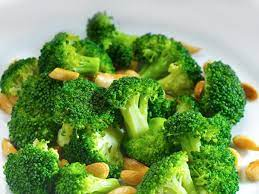

In [90]:
img = load_image(sample_image_path)
img_s = transforms.ToPILImage()(img)
img_t = process_img(img)
img_s
transforms.ToPILImage()(img_t.squeeze(0))
img_s

In [87]:
# images_src[sel]

In [88]:
# index, prob = predict(m, sel)
index, prob = predict_img(m, img_t)
index, prob

(937, 7.950499534606934)

In [89]:
labels_mapping[index]

'n07714990 broccoli\n'

In [38]:
pred = m(images_t[0].unsqueeze(0))

In [74]:
correct_prediction = 0
for index, label in enumerate(labels):
    predicted_label, _ = predict(m, index)
    if predicted_label == label:
        correct_prediction += 1
correct_prediction

962

In [32]:
images_t[0].shape

torch.Size([3, 224, 224])

In [58]:
import shutil
destination = "../pre_trained_models/image_cls_quant"
try:
    os.mkdir(destination)
except:
    pass
for m in success_load:
    shutil.copy(m, destination)